# Ward-Tordai Model Testing Notebook

This notebook is used for testing the Ward-Tordai model implementation and the plotting/fitting functionality.

In [17]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
import Ward_Tordai as wt
import plotting_and_fitting as pf
import pandas as pd
from scipy.optimize import curve_fit

%matplotlib inline

## Generate Sample Data

Generate synthetic surface tension data for testing purposes.

In [ ]:
# Generate sample time data (in seconds)
time = np.linspace(0.1, 100, 50)

# Generate sample surface tension data (in mN/m)
# Simulating a typical dynamic surface tension curve
gamma_0 = 72.0  # Initial surface tension (water)
gamma_eq = 40.0  # Equilibrium surface tension
k = 0.1  # Rate constant

surface_tension = gamma_eq + (gamma_0 - gamma_eq) * np.exp(-k * np.sqrt(time))

# Add some noise to make it realistic
noise = np.random.normal(0, 0.5, len(time))
surface_tension_noisy = surface_tension + noise

print(f"Time range: {time[0]:.2f} - {time[-1]:.2f} s")
print(f"Surface tension range: {surface_tension_noisy.min():.2f} - {surface_tension_noisy.max():.2f} mN/m")

## Plot Sample Data

Visualize the generated data using the plotting functions.

In [ ]:
# Plot the sample data
pf.plot_surface_tension_vs_time(time, surface_tension_noisy, 
                                 title="Sample Dynamic Surface Tension Data")

## Test Model Fitting

Fit a model to the data and visualize the results.

In [ ]:
# Define a simple model function
def simple_model(t, gamma_eq, gamma_0, k):
    return gamma_eq + (gamma_0 - gamma_eq) * np.exp(-k * np.sqrt(t))

# Initial parameter guesses
initial_params = [45.0, 70.0, 0.05]

# Fit the model
popt, pcov = pf.fit_model(time, surface_tension_noisy, simple_model, initial_params)

print(f"Fitted parameters:")
print(f"  gamma_eq = {popt[0]:.2f} mN/m")
print(f"  gamma_0 = {popt[1]:.2f} mN/m")
print(f"  k = {popt[2]:.4f}")

# Generate fitted data
fitted_surface_tension = simple_model(time, *popt)

## Visualize Fit Results

In [ ]:
# Plot data with fit
pf.plot_data_with_fit(time, surface_tension_noisy, fitted_surface_tension,
                      title="Dynamic Surface Tension with Model Fit")

## Analyze Residuals

In [ ]:
# Plot residuals
pf.residual_plot(time, surface_tension_noisy, fitted_surface_tension)

## Plot raw data and plot calibration data, save fit parameters

<>:4: SyntaxWarning: invalid escape sequence '\C'
<>:4: SyntaxWarning: invalid escape sequence '\C'
C:\Users\mape3\AppData\Local\Temp\ipykernel_16876\2342658633.py:4: SyntaxWarning: invalid escape sequence '\C'
  calibration=pd.read_csv("Example Data\Calibration.csv", delimiter=",")


Text(0.5, 0, 'Bubble life time [ms]')

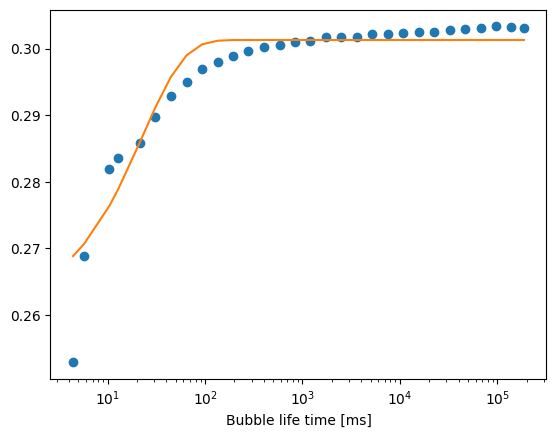

In [ ]:
# Import data from txt file
import json

calibration=pd.read_csv("Example Data\Calibration.csv", delimiter=",")

# Extract JSON metadata from column headers
calibrationmeta = {}
for col in calibration.columns:
    if '#' in col:
        # Split the column name at the '#' character
        col_name, json_data = col.split('#', 1)
        # Store the JSON data
        calibrationmeta[col_name] = json_data
        # Rename the column to remove JSON metadata
        calibration.rename(columns={col: col_name}, inplace=True)

lifetime=np.array(calibration["bubble life time[ms]2"])

# Plot calibration data
plt.plot(calibration["bubble life time[ms]2"], calibration["SFT"], 'o')
plt.xscale('log')

#create exponential fit function
def expfit(x, a, b, c):
    return a * np.exp(-b * x) + c
#fit the data
popt, pcov = curve_fit(expfit, calibration["bubble life time[ms]2"], calibration["exp"], p0=(30, 0.001, 40))
plt.plot(calibration["bubble life time[ms]2"], expfit(calibration["bubble life time[ms]2"], *popt), '-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))
plt.xlabel('Bubble life time [ms]')

## Notes

- Add more test cases as needed
- Test with real experimental data when available
- Validate numerical integration methods